# Stats on the preliminary (because its bad) expanded rated dataset, covering Metabolomics and Genomics

In [12]:
import os
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import asyncio
import json
import nest_asyncio
nest_asyncio.apply()
import asyncio

import pubmetric.network as nw
import pubmetric.metrics as met
import random
import pubmetric.pckg_dev as dev
import pubmetric.workflow as wf

from style import palette

In [6]:
proteomics_path = '../out/out_20240814142510' 
proteomics_graph = asyncio.run(nw.create_network(inpath=proteomics_path, load_graph=True))

metabolomics_path = '../out/out_20240814143203' 
metabolomics_graph = asyncio.run(nw.create_network(inpath=metabolomics_path, load_graph=True))

genomics_path = '../out/out_20240814151828' 
genomics_graph = asyncio.run(nw.create_network(inpath=genomics_path, load_graph=True))

graph_list = [proteomics_graph, metabolomics_graph, genomics_graph]
graph_name_list = ["Proteomics Domain", "Metabolomics Domain", "Genomics Domain"]
graph_stat_list = [(1874, 1527), (695, 585), (1778, 1540)] # (nr of tools in domain, tools in domain with pmid)

2024-08-16 14:11:19 - Loading graph from ../out/out_20240814142510/graph.pkl.
2024-08-16 14:11:19 - Graph loaded from ../out/out_20240814142510/graph.pkl.
2024-08-16 14:11:19 - Complete data download and graph creation took 0:00:00.020641
2024-08-16 14:11:19 - Loading graph from ../out/out_20240814143203/graph.pkl.
2024-08-16 14:11:19 - Graph loaded from ../out/out_20240814143203/graph.pkl.
2024-08-16 14:11:19 - Complete data download and graph creation took 0:00:00.003561
2024-08-16 14:11:19 - Loading graph from ../out/out_20240814151828/graph.pkl.
2024-08-16 14:11:19 - Graph loaded from ../out/out_20240814151828/graph.pkl.
2024-08-16 14:11:19 - Complete data download and graph creation took 0:00:00.020964


In [33]:
genomics_workflow_list = []
metabolomics_workflow_list = []

for i in range(1,145):
    if '8' in str(i) or '9' in str(i):
        continue
    cwl_file_path = f"/home/alma/Documents/UU/Thesis/APE_UseCases/genomics_APE-2.4/CWL/candidate_workflow_{i}.cwl" #
    genomics_workflow = wf.parse_undocumented_workflows(genomics_graph, cwl_file_path)
    genomics_workflow_list.append(genomics_workflow)

for i in range(1,254):
    if '8' in str(i) or '9' in str(i):
        continue
    cwl_file_path = f"/home/alma/Documents/UU/Thesis/APE_UseCases/genomics_APE-2.4/metabolomics_3/CWL/candidate_workflow_{i}.cwl"
    metabolomics_workflow = wf.parse_undocumented_workflows(metabolomics_graph, cwl_file_path)
    metabolomics_workflow_list.append(metabolomics_workflow)


In [60]:
genomics_workflow_list = []
genomics_tools = []
genomics_edges = []
discarded_workflow_count = 0  

# Process genomics workflows
for i in range(1, 145):
    if '8' in str(i) or '9' in str(i):
        continue
    cwl_file_path = f"/home/alma/Documents/UU/Thesis/APE_UseCases/genomics_APE-2.4/CWL/candidate_workflow_{i}.cwl"
    workflow = wf.parse_undocumented_workflows(genomics_graph, cwl_file_path)
    
    if workflow['edges'] in [wf['edges'] for wf in genomics_workflow_list]:
        print('Repetition')
        continue

    workflow_pmids = workflow['steps'].values()
    if len([pmid for pmid in workflow_pmids if not pmid]) <= 1:
        genomics_tools += workflow_pmids
        genomics_edges += [(edge[0], edge[1]) for edge in workflow['edges']]
        
        genomics_workflow_list.append(workflow)
    else:
        discarded_workflow_count += 1

print(f"Number of discarded workflows: {discarded_workflow_count}")

metabolomics_workflow_list = []
metabolomics_tools = []
metabolomics_edges = []
discarded_workflow_count = 0  # Counter for discarded workflows


# Process metabolomics workflows
for i in range(1, 254):
    if '8' in str(i) or '9' in str(i):
        continue
    cwl_file_path = f"/home/alma/Documents/UU/Thesis/APE_UseCases/genomics_APE-2.4/metabolomics_3/CWL/candidate_workflow_{i}.cwl"
    workflow = wf.parse_undocumented_workflows(metabolomics_graph, cwl_file_path)
    
    if workflow['edges'] in [ wf['edges'] for wf in metabolomics_workflow_list]:
        print('Repetition')
        continue

    workflow_pmids = workflow['steps'].values()
    if len([pmid for pmid in workflow_pmids if not pmid]) <= 1:

        metabolomics_tools += workflow_pmids
        metabolomics_edges += [(edge[0], edge[1]) for edge in workflow['edges']]
        metabolomics_workflow_list.append(workflow)
    else:
        # Increment counter for discarded workflows
        discarded_workflow_count += 1
print(f"Number of discarded workflows: {discarded_workflow_count}")
print(len(metabolomics_workflow_list), len(genomics_workflow_list))

Number of discarded workflows: 70
Number of discarded workflows: 105
66 30


In [62]:
workflow_average_score = []
connectivity_score = []
citation_scores = []
path_scores = []

# Ensure genomics is the shorter list
min_length = min(len(genomics_workflow_list), len(metabolomics_workflow_list))

# Loop over the shorter length (genomics list)
for i in range(min_length):
    workflow = genomics_workflow_list[i]
    metab_workflow = metabolomics_workflow_list[i]

    workflow_average_score.append((
        met.workflow_average_sum(graph=genomics_graph, workflow=workflow['pmid_edges']),
        met.workflow_average_sum(graph=genomics_graph, workflow=metab_workflow['pmid_edges']),
    ))

    connectivity_score.append((
        met.connectivity(graph=genomics_graph, workflow=workflow),
        met.connectivity(graph=genomics_graph, workflow=metab_workflow),
    ))

    citation_scores.append((
        met.median_citations(graph=genomics_graph, workflow=workflow),
        met.median_citations(graph=genomics_graph, workflow=metab_workflow),
    ))

    path_scores.append((
        met.shortest_path(graph=genomics_graph, workflow=workflow['pmid_edges']),
        met.shortest_path(graph=genomics_graph, workflow=metab_workflow['pmid_edges']),
    ))


/tmp/ipykernel_359816/160626853.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1, 1))


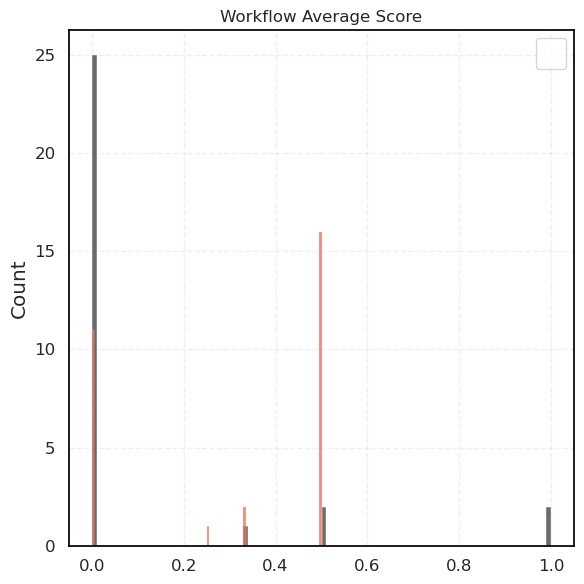

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))

nr_bins = 100
# Unpack the metrics
ape_scores, completely_random_scores = zip(*workflow_average_score)
# Invert the completely random scores

# Plot the histogram
sns.histplot(completely_random_scores, bins=nr_bins, ax=ax, color=palette[1])
sns.histplot(ape_scores, bins=nr_bins, ax=ax, color=palette[0])

# Set title and legend
ax.set_title('Workflow Average Score')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
# plt.xscale('log')
plt.tight_layout()
plt.show()


In [64]:
unique_genomics_tools = np.unique([t for wf in genomics_workflow_list for t in wf['steps'].values() if t])
unique_metabolomics_tools = np.unique([t for wf in metabolomics_workflow_list for t in wf['steps'].values() if t])

unique_genomics_edges = np.unique([edge for wf in genomics_workflow_list for edge in wf['edges'] if edge])
unique_metabolomics_edges = np.unique([edge for wf in metabolomics_workflow_list for edge in wf['edges'] if edge])

print(f"Number of unique genomics tools: {len(unique_genomics_tools)}")
print(f"Number of unique metabolomics tools: {len(unique_metabolomics_tools)}")

print(f"Number of unique genomics edges: {len(unique_genomics_edges)}")
print(f"Number of unique metabolomics edges: {len(unique_metabolomics_edges)}")


Number of unique genomics tools: 15
Number of unique metabolomics tools: 9
Number of unique genomics edges: 37
Number of unique metabolomics edges: 26


Yeah we have to try that again